In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from tensorflow import keras

### Data (Sequence-Sequence)

In [2]:
def generate_time_series (m, n_seq):
    freq1, freq2, offsets1, offsets2 = np. random. rand (4, m, 1)
    time = np. linspace(0, 1, n_seq)
    series = 0.5* np.cos((time - offsets1) * (freq1 * 10+10))
    series += 0.3* np. sin((time - offsets2) * (freq2 * 20+20))
    series += 0.1 * (np.random. rand(m, n_seq) - 0.5)
    return series [..., np.newaxis].astype(np. float32)

In [3]:
np. random. seed (1)
#用前面 30筆序列來預測后 10筆
n_seq = 30
n_pred = 10

series = generate_time_series (5000, n_seq + n_pred)#5000樣本數
series.shape

(5000, 40, 1)

In [4]:
x_train = series [:3000, :n_seq]
x_valid = series [3000:4000, : n_seq]
x_test =series [4000:, :n_seq]

In [5]:
y = np.empty ((5000, n_seq, n_pred))

for step_ahead in range(1, n_pred + 1) :
    y[..., step_ahead - 1] = series [..., step_ahead:step_ahead + n_seq, 0]

y_train = y[:3000]
y_valid = y [3000:4000]
y_test = y [4000:]

In [6]:
x_train.shape, y_train. shape

((3000, 30, 1), (3000, 30, 10))

In [7]:
def plot_seq(x, y, y_pred=None) :
    plt.plot(x,'.-')
    n_seq = x. shape [0]
    ahead = y. shape [0]
    
    plt.plot (np.arange (n_seq, n_seq + ahead), y, 'go-', label= '$y$') 
    if y_pred is not None:
        plt.plot(np.arange (n_seq, n_seq + ahead), y_pred, 'rx-',
                 label='$\hat y$', markersize=10)
    plt.hlines (0, 0, n_seq + ahead, linewidth=1) 
    plt.axis([0, n_seq + ahead, -1, 1]) 
    plt.grid(True)
    plt. legend (fontsize=14)

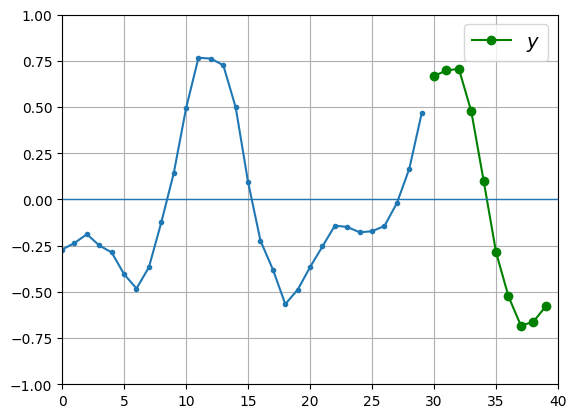

In [8]:
plot_seq(x_test[0, :, 0], y_test[0, -1])

# (GRUs)
## /(Build Model)

In [9]:
np. random. seed (1)
tf. random. set_seed (1)

In [10]:
model = keras. models. Sequential([
    #每層有20個神經元，並返回時間序列的資料 
    keras. layers. GRU(20, return_sequences=True, input_shape= [None, 1]), 
    keras. layers. GRU(20, return_sequences=True), 
    keras. layers. TimeDistributed (keras. layers. Dense (10))#記錄最后的結果
])

In [11]:
model.summary()
'''
#一layer有 20神經元，各自會對應到1個W,1個b-->對應 20個神經元 -->3層   
 lstm (GRU)/(None, None, 20)/1380 = [(2b+1+20)*20]*3 
#一layer有 20神經元，各自會對應到20個input,1個b-->對應 20個神經元 -->4層
 lstm_1 (GRU)/(None, None, 20)/2520 = [(2b+20上一層input+20回傳)*20]*3     
#不用再回傳                                       
 time_distributed (TimeDistributed)/(None, None, 10)/210 = (1+20)*10        
'''

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 20)          1380      
                                                                 
 gru_1 (GRU)                 (None, None, 20)          2520      
                                                                 
 time_distributed (TimeDistr  (None, None, 10)         210       
 ibuted)                                                         
                                                                 
Total params: 4,110
Trainable params: 4,110
Non-trainable params: 0
_________________________________________________________________


'\n#一layer有 20神經元，各自會對應到1個W,1個b-->對應 20個神經元 -->4層   \n lstm (LSTM)/(None, None, 20)/1760 = [(1+1+20)*20]*4 \n\n#一layer有 20神經元，各自會對應到20個input,1個b-->對應 20個神經元 -->4層                                       \n lstm_1 (LSTM)/(None, None, 20)/3280 = [(1b+20上一層input+20回傳)*20]*4     \n\n#不用再回傳                                       \n time_distributed (TimeDistributed)/(None, None, 10)/210 = (1+20)*10        \n'

### 2. Compile

In [12]:
def last_time_step_mse(y_true, y_pred):
    return keras. metrics.mean_squared_error(y_true[:,-1], y_pred[:,-1]) 
    
model. compile(loss='mse', optimizer=keras.optimizers.Adam( learning_rate=0.01),
               metrics=[last_time_step_mse])

### 3. Train

In [13]:
train = model. fit(x_train, y_train, epochs=20, 
                   validation_data=(x_valid, y_valid))

Epoch 1/20
94/94 [==============================] - 10s 48ms/step - loss: 0.1009 - last_time_step_mse: 0.0941 - val_loss: 0.0861 - val_last_time_step_mse: 0.0768
Epoch 2/20
94/94 [==============================] - 3s 36ms/step - loss: 0.0760 - last_time_step_mse: 0.0611 - val_loss: 0.0732 - val_last_time_step_mse: 0.0529
Epoch 3/20
94/94 [==============================] - 4s 45ms/step - loss: 0.0618 - last_time_step_mse: 0.0379 - val_loss: 0.0577 - val_last_time_step_mse: 0.0315
Epoch 4/20
94/94 [==============================] - 4s 38ms/step - loss: 0.0507 - last_time_step_mse: 0.0237 - val_loss: 0.0459 - val_last_time_step_mse: 0.0180
Epoch 5/20
94/94 [==============================] - 3s 36ms/step - loss: 0.0428 - last_time_step_mse: 0.0156 - val_loss: 0.0398 - val_last_time_step_mse: 0.0131
Epoch 6/20
94/94 [==============================] - 3s 36ms/step - loss: 0.0392 - last_time_step_mse: 0.0127 - val_loss: 0.0401 - val_last_time_step_mse: 0.0166
Epoch 7/20
94/94 [===============

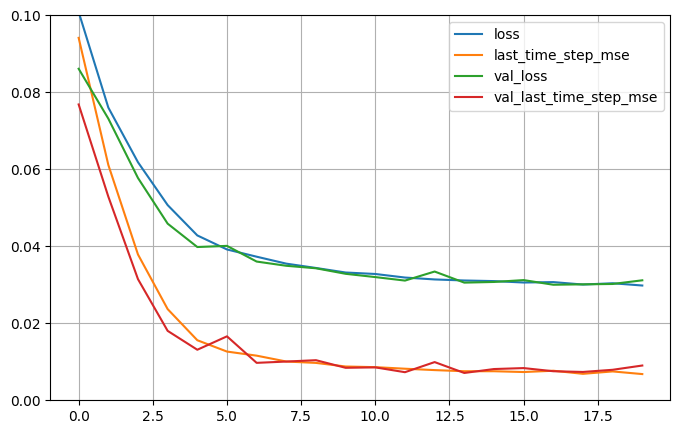

In [14]:
pd. DataFrame(train.history).plot(figsize=(8,5))
plt.grid(True)
plt.ylim(0, 0.1) 
plt. show()

### 4. Evaluate

In [15]:
model.evaluate(x_test, y_test)

32/32 [==============================] - 0s 8ms/step - loss: 0.0311 - last_time_step_mse: 0.0085


[0.031092500314116478, 0.008492054417729378]

### 5. Predict

In [16]:
y_pred = model.predict(x_test)

print(y_test.shape, y_pred.shape)

32/32 [==============================] - 1s 8ms/step
(1000, 30, 10) (1000, 30, 10)


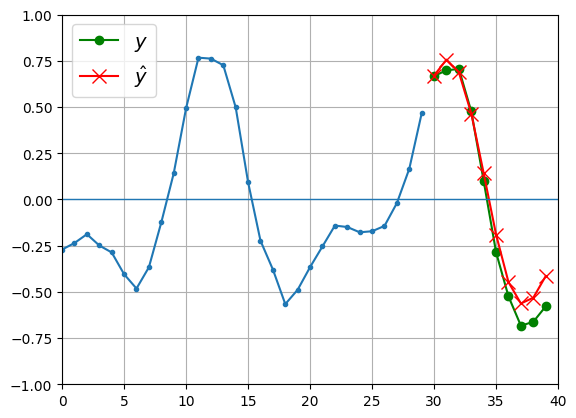

In [17]:
i = 0
plot_seq(x_test[i, :, 0], y_test[i, -1], y_pred[i, -1])   